In [1]:
!pip install torch-pconv
!pip install opencv-python

In [2]:
import tensorflow as tf
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

import os
import time
import matplotlib.pyplot as plt
import pathlib
from IPython.display import clear_output
from datetime import datetime
from sklearn.metrics import mean_squared_error
import numpy as np
import cv2
from glob import glob
from torch_pconv import PConv2d

mse = tf.keras.losses.MeanSquaredError()

AUTOTUNE = tf.data.AUTOTUNE

2023-12-01 17:04:51.706327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 17:04:52.674245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Canny edge detection for training data

# fileList = glob("/hdd/Datasets/sar2opt_raw_data/split_data/train/s2_rgb_tiles/*.png")
# for file in fileList:
#     img = cv2.imread(file)
#     blurred = cv2.GaussianBlur(img, (3, 3), 0)
#     edge = cv2.Canny(blurred, 30, 150)
#     img_id = file.split("/")[-1].split(".")[0]
#     cv2.imwrite(f"/hdd/Datasets/sar2opt_raw_data/split_data/train/s2_edge_tiles/{img_id}.png", edge)

In [4]:
sar_rgb = cv2.imread("/hdd/Datasets/sar2opt_raw_data/split_data/train/s1_rgb_tiles/16.png")
sar_gray = cv2.imread("/hdd/Datasets/sar2opt_raw_data/split_data/train/s1_gray_tiles/16.png")
sar_edge = cv2.imread("/hdd/Datasets/sar2opt_raw_data/split_data/train/s1_edge_tiles/16.png")

In [5]:
#!pip install git+https://github.com/tensorflow/examples.git

In [6]:
#from tensorflow_examples.models.pix2pix import pix2pix

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-12-01 17:04:59.744784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 17:04:59.747583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 17:04:59.747907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def load_img(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  sar_image = image[:, w:, :]
  opt_image = image[:, :w, :]

  # Convert both images to float32 tensors
  sar_image = tf.cast(sar_image, tf.float32)
  opt_image = tf.cast(opt_image, tf.float32)
    
  return sar_image, opt_image

In [10]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image


In [11]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [12]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


In [13]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image


In [14]:
def preprocess_image_train(image_file):
  input_image, real_image = load_img(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [15]:
def preprocess_image_test(image_file):
  input_image, real_image = load_img(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [16]:
train_path = pathlib.Path('/hdd/Datasets/sar2opt_raw_data/train')
test_path = pathlib.Path('/hdd/Datasets/sar2opt_raw_data/test')
train_filenames = tf.constant([os.path.join(train_path, fname) for fname in os.listdir(train_path)])
test_filenames = tf.constant([os.path.join(test_path, fname) for fname in os.listdir(test_path)])
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames))

2023-12-01 17:05:07.546509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 17:05:07.546952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 17:05:07.547318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
train_dataset = train_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).batch(
    BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.cache().map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).batch(
    BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
sample_sar, sample_opt = next(iter(train_dataset))

2023-12-01 17:05:14.108455: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


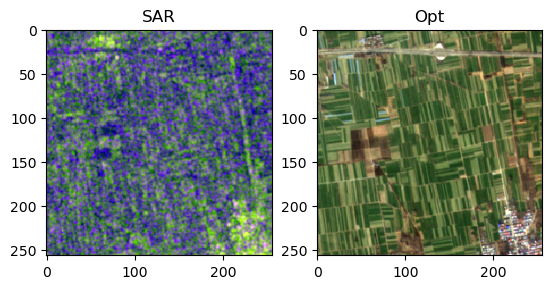

In [19]:
plt.subplot(121)
plt.title('SAR')
plt.imshow(sample_sar[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Opt')
plt.imshow(sample_opt[0] * 0.5 + 0.5)


In [ ]:
plt.subplot(121)
plt.title('SAR')
plt.imshow(sample_sar[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Opt')
img = np.uint8(sample_sar[0])
blurred = cv2.GaussianBlur(img, (3, 3), 0)
plt.imshow(cv2.Canny(blurred, 30, 150))

In [ ]:
plt.subplot(121)
plt.title('SAR')
plt.imshow(sample_sar[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('SAR with random jitter')
sar, _ = random_jitter(sample_sar[0] * 0.5 + 0.5, sample_opt[0] * 0.5 + 0.5)
plt.imshow(sar)


In [ ]:
plt.subplot(121)
plt.title('SAR')
plt.imshow(sample_opt[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('OPT with random jitter')
_, opt = random_jitter(sample_sar[0] * 0.5 + 0.5, sample_opt[0] * 0.5 + 0.5)
plt.imshow(opt)


---
## Step 3: Making the Generator (G) Model
The generator is an encoder-decoder model architecture. 

In [21]:
def downsample(in_channels, out_channels, filter_size, padding, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = nn.Sequential(
                PConv2d(in_channels, out_channels, filter_size, stride=2, padding=padding, 
                        kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

In [25]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(3, 64, 7, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(64, 128, 5, 2),  # (batch_size, 64, 64, 128)
    downsample(128, 256, 5, 2),  # (batch_size, 32, 32, 256)
    downsample(256, 512, 3, 1),  # (batch_size, 16, 16, 512)
    downsample(512, 512, 3, 1),  # (batch_size, 8, 8, 512)
    downsample(512, 512, 3, 1),  # (batch_size, 4, 4, 512)
    downsample(512, 512, 3, 1),  # (batch_size, 2, 2, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.Ws = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.Wt = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.patch_size = 3
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, dilation=1, padding=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, dilation=2, padding=2)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, dilation=4, padding=4)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, dilation=8, padding=8)
        self.weights = nn.Conv2d(256, 256 * 4, kernel_size=1)

        # Texture Encoder
        self.t_encoder_pconv1 = PConv2d(3, 64, 7, 2, 3)
        self.t_encoder_pconv2 = PConv2d(64, 128, 5, 2, 2)
        self.t_encoder_pconv2_bn = nn.BatchNorm2d(128)
        self.t_encoder_pconv3 = PConv2d(128, 256, 5, 2, 2)
        self.t_encoder_pconv3_bn = nn.BatchNorm2d(256)
        self.t_encoder_pconv4 = PConv2d(256, 512, 3, 2, 1)
        self.t_encoder_pconv4_bn = nn.BatchNorm2d(512)
        self.t_encoder_pconv5 = PConv2d(512, 512, 3, 2, 1)
        self.t_encoder_pconv5_bn = nn.BatchNorm2d(512)
        self.t_encoder_pconv6 = PConv2d(512, 512, 3, 2, 1)
        self.t_encoder_pconv6_bn = nn.BatchNorm2d(512)
        self.t_encoder_pconv7 = PConv2d(512, 512, 3, 2, 1)

        # Structure Encoder
        self.s_encoder_pconv1 = PConv2d(2, 64, 7, 2, 3)
        self.s_encoder_pconv2 = PConv2d(64, 128, 5, 2, 2)
        self.s_encoder_pconv2_bn = nn.BatchNorm2d(128)
        self.s_encoder_pconv3 = PConv2d(128, 256, 5, 2, 2)
        self.s_encoder_pconv3_bn = nn.BatchNorm2d(256)
        self.s_encoder_pconv4 = PConv2d(256, 512, 3, 2, 1)
        self.s_encoder_pconv4_bn = nn.BatchNorm2d(512)
        self.s_encoder_pconv5 = PConv2d(512, 512, 3, 2, 1)
        self.s_encoder_pconv5_bn = nn.BatchNorm2d(512)
        self.s_encoder_pconv6 = PConv2d(512, 512, 3, 2, 1)
        self.s_encoder_pconv6_bn = nn.BatchNorm2d(512)
        self.s_encoder_pconv7 = PConv2d(512, 512, 3, 2, 1)

        # Texture Decoder
        self.t_decoder_pconv8 = nn.ConvTranspose2d(1024, 512, 3, 1, 1)
        self.t_decoder_pconv8_bn = nn.BatchNorm2d(512)
        self.t_decoder_pconv9 = nn.ConvTranspose2d(1024, 512, 3, 1, 1)
        self.t_decoder_pconv9_bn = nn.BatchNorm2d(512)
        self.t_decoder_pconv10 = nn.ConvTranspose2d(1024, 512, 3, 1, 1)
        self.t_decoder_pconv10_bn = nn.BatchNorm2d(512)
        self.t_decoder_pconv11 = nn.ConvTranspose2d(768, 256, 3, 1, 1)
        self.t_decoder_pconv11_bn = nn.BatchNorm2d(256)
        self.t_decoder_pconv12 = nn.ConvTranspose2d(384, 128, 3, 1, 1)
        self.t_decoder_pconv12_bn = nn.BatchNorm2d(128)
        self.t_decoder_pconv13 = nn.ConvTranspose2d(192, 64, 3, 1, 1)
        self.t_decoder_pconv13_bn = nn.BatchNorm2d(64)
        self.t_decoder_pconv14 = nn.ConvTranspose2d(67, 64, 3, 1, 1)  # Texture Feature

        # Structure Decoder
        self.s_decoder_pconv15 = nn.ConvTranspose2d(1024, 512, 3, 1, 1)
        self.s_decoder_pconv15_bn = nn.BatchNorm2d(512)
        self.s_decoder_pconv16 = nn.ConvTranspose2d(1024, 512, 3, 1, 1)
        self.s_decoder_pconv16_bn = nn.BatchNorm2d(512)
        self.s_decoder_pconv17 = nn.ConvTranspose2d(1024, 512, 3, 1, 1)
        self.s_decoder_pconv17_bn = nn.BatchNorm2d(512)
        self.s_decoder_pconv18 = nn.ConvTranspose2d(768, 256, 3, 1, 1)
        self.s_decoder_pconv18_bn = nn.BatchNorm2d(256)
        self.s_decoder_pconv19 = nn.ConvTranspose2d(384, 128, 3, 1, 1)
        self.s_decoder_pconv19_bn = nn.BatchNorm2d(128)
        self.s_decoder_pconv20 = nn.ConvTranspose2d(192, 64, 3, 1, 1)
        self.s_decoder_pconv20_bn = nn.BatchNorm2d(64)
        self.s_decoder_pconv21 = nn.ConvTranspose2d(66, 64, 3, 1, 1)  # Structure Feature

    def bi_gff(self, fs, ft):
        # BI-GFF Module
        # Apply Ws and Wt to concatenated features
        concatenated_features = torch.cat((fs, ft), dim=1)
        fs_prime = self.Ws(concatenated_features)
        ft_prime = self.Wt(concatenated_features)

        # Perform element-wise multiplication
        fs_prime = fs_prime * ft
        ft_prime = ft_prime * fs

        # Perform element-wise addition
        fs_out = fs + fs_prime
        ft_out = ft + ft_prime

        # Concatenate the modified features along the channel dimension to obtain the fused features
        f_out = torch.cat((fs_out, ft_out), dim=1)
        return f_out

    def cfa(self, F_in):
        patches = F_in.unfold(2, self.patch_size, 1).unfold(3, self.patch_size, 1)
        patches = patches.contiguous().view(F_in.size(0), F_in.size(1), -1, self.patch_size, self.patch_size)

        # Compute cosine similarity between patches
        patches_normalized = F.normalize(patches, p=2, dim=1)
        similarity_matrix = torch.einsum('bcijk,bcxyk->bixy', [patches_normalized, patches_normalized])
        return similarity_matrix

        # # Apply softmax to similarity matrix to obtain attention scores
        # attention_scores = F.softmax(similarity_matrix, dim=-1)
        
        # # Reconstruct the feature map from the attention scores and patches
        # F_rec = torch.einsum('bixy,bcijk->bcxyk', [attention_scores, patches])
        # F_rec = F_rec.contiguous().view(F_in.size(0), F_in.size(1), F_in.size(2), F_in.size(3))

        # F1_rec = self.conv1(F_rec)
        # F2_rec = self.conv2(F_rec)
        # F4_rec = self.conv4(F_rec)
        # F8_rec = self.conv8(F_rec)

        # weights = self.weights(F_rec)
        # W1, W2, W4, W8 = torch.split(weights, weights.size(1)//4, dim=1)

        # # Combine the multiscale features with the weights
        # F_rec_comb = (F1_rec * W1) + (F2_rec * W2) + (F4_rec * W4) + (F8_rec * W8)

        # # Use skip connection to combine the original encoder features with the reconstructed features
        # F_final = torch.cat((F_rec_comb, encoder_features), dim=1)

        #return F_final
        
        

    def forward(self, t_encoder_inp, t_encoder_mask, s_encoder_inp_gray, s_encoder_inp_edge):
        # Texture Encoder
        t_e1, t_m1 = self.t_encoder_pconv1(t_encoder_inp, t_encoder_mask)
        t_e2, t_m2 = self.t_encoder_pconv2(F.relu(t_e1), t_m1)
        t_e2       = self.t_encoder_pconv2_bn(t_e2)
        t_e3, t_m3 = self.t_encoder_pconv3(F.relu(t_e2), t_m2)
        t_e3       = self.t_encoder_pconv3_bn(t_e3)
        t_e4, t_m4 = self.t_encoder_pconv4(F.relu(t_e3), t_m3)
        t_e4       = self.t_encoder_pconv4_bn(t_e4)
        t_e5, t_m5 = self.t_encoder_pconv5(F.relu(t_e4), t_m4)
        t_e5       = self.t_encoder_pconv5_bn(t_e5)
        t_e6, t_m6 = self.t_encoder_pconv6(F.relu(t_e5), t_m5)
        t_e6       = self.t_encoder_pconv6_bn(t_e6)
        t_e7, t_m7 = self.t_encoder_pconv7(F.relu(t_e6), t_m6)


        # Structure Encoder
        s_e1, s_m1 = self.s_encoder_pconv1(s_encoder_inp_gray, s_encoder_inp_edge)
        s_e2, s_m2 = self.s_encoder_pconv2(F.relu(s_e1), s_m1)
        s_e2     = self.s_encoder_pconv2_bn(s_e2)
        s_e3, s_m3 = self.s_encoder_pconv3(F.relu(s_e2), s_m2)
        s_e3     = self.s_encoder_pconv3_bn(s_e3)
        s_e4, s_m4 = self.s_encoder_pconv4(F.relu(s_e3), s_m3)
        s_e4     = self.s_encoder_pconv4_bn(s_e4)
        s_e5, s_m5 = self.s_encoder_pconv5(F.relu(s_e4), s_m4)
        s_e5     = self.s_encoder_pconv5_bn(s_e5)
        s_e6, s_m6 = self.s_encoder_pconv6(F.relu(s_e5), s_m5)
        s_e6     = self.s_encoder_pconv6_bn(s_e6)
        s_e7, s_m7 = self.s_encoder_pconv7(F.relu(s_e6), s_m6)

        # Texture Decoder
        s_e7_upsampled = F.interpolate(s_e7, size=(4, 4), mode='bilinear', align_corners=False)
        t_d1 = torch.cat([s_e7_upsampled, t_e6], 1)
        t_d1 = F.dropout(self.t_decoder_pconv8_bn(self.t_decoder_pconv8(F.leaky_relu(t_d1))), 0.5, training=True)
        
        t_d1_upsampled = F.interpolate(t_d1, size=(8, 8), mode='bilinear', align_corners=False)
        t_d2 = torch.cat([t_d1_upsampled, t_e5], 1)
        t_d2 = F.dropout(self.t_decoder_pconv9_bn(self.t_decoder_pconv9(F.leaky_relu(t_d2))), 0.5, training=True)
        
        t_d2_upsampled = F.interpolate(t_d2, size=(16, 16), mode='bilinear', align_corners=False)
        t_d3 = torch.cat([t_d2_upsampled, t_e4], 1)
        t_d3 = self.t_decoder_pconv10_bn(self.t_decoder_pconv10(F.leaky_relu(t_d3)))
        
        t_d3_upsampled = F.interpolate(t_d3, size=(32, 32), mode='bilinear', align_corners=False) 
        t_d4 = torch.cat([t_d3_upsampled, t_e3], 1)
        t_d4 = self.t_decoder_pconv11_bn(self.t_decoder_pconv11(F.leaky_relu(t_d4)))

        t_d4_upsampled = F.interpolate(t_d4, size=(64, 64), mode='bilinear', align_corners=False) 
        t_d5 = torch.cat([t_d4_upsampled, t_e2], 1)
        t_d5 = self.t_decoder_pconv12_bn(self.t_decoder_pconv12(F.leaky_relu(t_d5)))
        
        t_d5_upsampled = F.interpolate(t_d5, size=(128, 128), mode='bilinear', align_corners=False) 
        t_d6 = torch.cat([t_d5_upsampled, t_e1], 1)
        t_d6 = self.t_decoder_pconv13_bn(self.t_decoder_pconv13(F.leaky_relu(t_d6)))

        t_d6_upsampled = F.interpolate(t_d6, size=(256, 256), mode='bilinear', align_corners=False) 
        t_d7 = torch.cat([t_d6_upsampled, t_encoder_inp], 1)
        texture_feature = self.t_decoder_pconv14(F.leaky_relu(t_d7))

        # Structure Decoder
        t_e7_upsampled = F.interpolate(t_e7, size=(4, 4), mode='bilinear', align_corners=False)
        s_d1 = torch.cat([t_e7_upsampled, s_e6], 1)
        s_d1 = F.dropout(self.s_decoder_pconv15_bn(self.s_decoder_pconv15(F.leaky_relu(s_d1))), 0.5, training=True)

        s_d1_upsampled = F.interpolate(s_d1, size=(8, 8), mode='bilinear', align_corners=False)
        s_d2 = torch.cat([s_d1_upsampled, s_e5], 1)
        s_d2 = F.dropout(self.s_decoder_pconv16_bn(self.s_decoder_pconv16(F.leaky_relu(s_d2))), 0.5, training=True)

        s_d2_upsampled = F.interpolate(s_d2, size=(16, 16), mode='bilinear', align_corners=False)
        s_d3 = torch.cat([s_d2_upsampled, s_e4], 1)
        s_d3 = self.s_decoder_pconv17_bn(self.s_decoder_pconv17(F.leaky_relu(s_d3)))

        s_d3_upsampled = F.interpolate(s_d3, size=(32, 32), mode='bilinear', align_corners=False)
        s_d4 = torch.cat([s_d3_upsampled, s_e3], 1)
        s_d4 = self.s_decoder_pconv18_bn(self.s_decoder_pconv18(F.leaky_relu(s_d4)))

        s_d4_upsampled = F.interpolate(s_d4, size=(64, 64), mode='bilinear', align_corners=False)
        s_d5 = torch.cat([s_d4_upsampled, s_e2], 1)
        s_d5 = self.s_decoder_pconv19_bn(self.s_decoder_pconv19(F.leaky_relu(s_d5)))

        s_d5_upsampled = F.interpolate(s_d5, size=(128, 128), mode='bilinear', align_corners=False)
        s_d6 = torch.cat([s_d5_upsampled, s_e1], 1)
        s_d6 = self.s_decoder_pconv20_bn(self.s_decoder_pconv20(F.leaky_relu(s_d6)))

        s_d6_upsampled = F.interpolate(s_d6, size=(256, 256), mode='bilinear', align_corners=False)
        s_d7 = torch.cat([s_d6_upsampled, s_encoder_inp_gray], 1)
        structure_feature = self.s_decoder_pconv21(F.leaky_relu(s_d7))

        F_in = self.bi_gff(structure_feature, texture_feature)
        F_out = self.cfa(F_in)

        

        return F_out



In [27]:
#generator = Generator()
def cv2torchRGB(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0
    img = img.transpose((2, 0, 1))
    img = torch.tensor(img)
    return img.unsqueeze(0)

def cv2torchGRAY(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype("float32") / 255.0
    #img = img.transpose((2, 0, 1))
    img = torch.tensor(img)
    if img.dim() == 2:
        img = img.unsqueeze(0).unsqueeze(0)
    else:
        img = img.unsqueeze(1)
    return img

s_in_gray = cv2torchGRAY(sar_gray)
s_in_edge = cv2torchGRAY(sar_edge)
s_in = torch.cat((s_in_gray, s_in_edge), dim=1)
t_in_rgb = cv2torchRGB(sar_rgb)

batch_size, channels, height, width = t_in_rgb.size()
t_in_mask = torch.ones(batch_size, 1, height, width, dtype=t_in_rgb.dtype, device=t_in_rgb.device)

generator = Generator()
f = generator(t_in_rgb, t_in_mask.squeeze(1), s_in, s_in_edge.squeeze(1))
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [29]:
f.shape

torch.Size([1, 64516, 64516, 3])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, pseudo_opt):
        super(Discriminator, self).__init__()
        blurred = cv2.GaussianBlur(pseudo_opt, (3, 3), 0)
        edge_features = cv2.Canny(blurred, 30, 150)
        return edge_features


blurred = cv2.GaussianBlur(img, (3, 3), 0)
plt.imshow(Discriminator())

## Discriminator
---

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(sar, 0))
print (down_result.shape)

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [ ]:
discriminator = Discriminator()
plot_model(discriminator, show_shapes=True, dpi=64)

---

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


In [ ]:
to_opt = generator_g(sample_sar)
to_sar = generator_f(sample_opt)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_sar, to_opt, sample_opt, to_sar]
title = ['SAR', 'To Opt', 'Opt', 'To SAR']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()


In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Optical image?')
plt.imshow(discriminator_y(sample_sar)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real SAR image?')
plt.imshow(discriminator_x(sample_opt)[0, ..., -1], cmap='RdBu_r')

plt.show()


In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "sar2opt/s_cyclegan/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
log_dir="sar2opt/s_cyclegan/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(real_x, real_y, step):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + mse(real_y, fake_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + mse(real_x, fake_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_g_total_loss', total_gen_g_loss, step)
    tf.summary.scalar('gen_g_loss', gen_g_loss, step)
    tf.summary.scalar('total_cycle_loss', total_cycle_loss, step)
    tf.summary.scalar('disc_x_loss', disc_x_loss, step)
    tf.summary.scalar('disc_y_loss', disc_y_loss, step)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir={log_dir} --host=0.0.0.0

In [ ]:
EPOCHS = 10

In [ ]:
tf.config.run_functions_eagerly(True)

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_dataset)):
    train_step(image_x, image_y, epoch)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_sar, sample_opt)

  #if (epoch + 1) % 5 == 0: 
  ckpt.save(file_prefix=checkpoint_prefix)
  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         checkpoint_prefix))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
import numpy as np
# Run the trained model on the test dataset
for sar, opt in test_sar_tiles.take(5):
  generate_images(generator_g, sar, opt)
